# Import Statements

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# importing spencers code
import GeoSim2D_Multipath as geoSim

# importing my functions
import NNDataPrep as prep
import CorrelationFunctions as myCorr
import NN_plotting as NNplots

# GPU code

In [2]:
# checking to see if Tensorflow can "see" the NN
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


# Adjustments

In [3]:
# There are 2 more NN they are slightly outdated, but they work with different inputs. 
# The first is a DoA NN that works with 3 elements and correlation data.
# The second is a DoA NN that works with 2 elements FFT data. This one wasn't used because the
# simulation time took to long

# Changes these variables to test different parameters for the NN
# Changes to the NN
# All of these values were determined by guess and check. Learning rate and epochs based off of loss curve. 
# batch size was mainly related to speed, but also affected the curve.

ACTIVATION_FUNCTION = 'sigmoid' # activation function being used for the NN 
LEARNING_RATE       = 0.000001  # learning rate for NN
EPOCHS              = 200       # number of epochs for the NN
BATCH_SIZE          = 100       # batchsize for the NN

# Changes to the GeoSim
MP = 0 # set to 1 if you want MP, set to 0 to remove MP
num_samples  = 512 # number of samples taken from original signal
antenna_dist = 500 # distance between RX and TX

# number of train and test sets
# About 20k training sets are need because batch size * epochs = 20k, so I went with 30 to be safe
# this is a rough approximation to figure out training size
num_sets      = 30000    # number of train signals to see results of the NN
test_num_sets = num_sets # number of test signals to see results of the NN

# The simulation of the signals takes 5-10 min to run
# The NN takes about 10-15 min to train depending on topolgy and epochs.

# Geo Sim (Generating the Train & Test Data)

In [ ]:
# creating blank arrays to store the values from the geometry simulator
elements            = [[], [], []] # empty matrix to store each elements data
test_elements       = [[], [], []] # empty matrix to store each elements data
angleofArrival      = [] # empty matrix to store DoA
test_angleofArrival = [] # empty matrix to store DoA
# angle of arrival is in degrees for the entire program, sometimes it is normalized between -1 and 1

In [ ]:
# Generating the data for testing and training
# output2 isn't used for the 2 element NN
# Currently only training with -45 to 45. Want to expand that range by adjusting antenna_dist

# Generating the training data
train_flag = 1 # set to 1 to use tain data
for i in range(num_sets):
    output0,output1,output2,anglemp,anglelos = geoSim.f_time(num_samples,MP,antenna_dist,train_flag)
    elements[0].append(output0)              # storing the data for element 1
    elements[1].append(output1)              # storing the data for element 2 
    angleofArrival.append(np.mean(anglelos)) # storing the AoA, taking the mean because returns 3 similar angles

# Generating the testing data
train_flag = 0 # set to 0 to use test data
for i in range(test_num_sets):
    output0,output1,output2,anglemp,anglelos = geoSim.f_time(num_samples,MP,antenna_dist,train_flag)
    test_elements[0].append(output0)              # storing the data for element 1
    test_elements[1].append(output1)              # storing the data for element 2 
    test_angleofArrival.append(np.mean(anglelos)) # storing the AoA, taking the mean because returns 3 similar angles

# Cross Correlation

In [ ]:
# Cross correlating elements 1 and 2, also changes from complex to polar
# Training Data
element1 = np.array(elements[0]) # Data setup for the correlation
element2 = np.array(elements[1]) # Data setup for the correlation
polarCorr, corr = myCorr.cross_corr(element1,element2,num_sets,num_samples)

# Testing Data
test_element1 = np.array(test_elements[0]) # Data setup for the correlation
test_element2 = np.array(test_elements[1]) # Data setup for the correlation
test_polarCorr, test_corr = myCorr.cross_corr(test_element1,test_element2,test_num_sets,num_samples) 

# Cross Correlation Output

In [ ]:
# Plotting the signal and correlation
# signal = 0 # signal from the set that you want to look at
# NNplots.plot_cross_corr_2_elements(corr,angleofArrival,element1,element3,signal) # plots the signals and cross correlation

In [ ]:
# Plotting the signal and correlation
# signal = 1 # signal from the set that you want to look at
# NNplots.plot_cross_corr_2_elements(corr,angleofArrival,element1,element3,signal) # plots the signals and cross correlation

# Data for NN

In [ ]:
# Setting the label and feature
# This normalizes the data from (-45,45) to (-1,1) for the labels. Similar for the feature
train_features, train_labels = prep.data_prep_2_elements(polarCorr,angleofArrival)
test_features,  test_labels  = prep.data_prep_2_elements(test_polarCorr,test_angleofArrival)

# Build NN

In [ ]:
# Create a `Sequential` model
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(num_samples*2))) # input layer
# The input shape is 2x the sample size because NN don't work with complex so needed to convert data to polar
# data has the shape [mag,...., phase.....]

model.add(tf.keras.layers.Dense(num_samples*4, activation = ACTIVATION_FUNCTION)) # first  hidden layer
model.add(tf.keras.layers.Dense(num_samples*4, activation = ACTIVATION_FUNCTION)) # second hidden layer
model.add(tf.keras.layers.Dense(1024, activation = ACTIVATION_FUNCTION))          # third  hidden layer
model.add(tf.keras.layers.Dense(1)) # output layer
model.output_shape

model.summary()

In [ ]:
# Settubg the optomizer, loss, and metric for the NN
model.compile(
    optimizer=Adam(learning_rate = LEARNING_RATE),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
# Runs the NN and saves it to history
history = model.fit(
    x = train_features, 
    y = train_labels,  
    validation_split = 0.1,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS, 
    verbose = 2)

# Predict

In [ ]:
# giving the trained NN unseen test data to see how well it learned
predictions = model.predict(x=test_features, batch_size=1, verbose=0)

In [ ]:
# rescaling the normilized output of the NN
scaler = MinMaxScaler(feature_range=(np.min(test_angleofArrival),np.max(test_angleofArrival))) 
scaled_predictions = scaler.fit_transform(predictions)

In [ ]:
# changing list to np so it can be reshaped to be used in data frames
test_angleofArrival = np.array(test_angleofArrival)
test_angleofArrival = test_angleofArrival.reshape((test_num_sets,1)) 

In [ ]:
# comparing predictions and labels to check output
data = np.hstack([predictions,test_labels])
df = pd.DataFrame(data, columns=['predictions','labels'])
print(df)

In [ ]:
# comparing predictions and labels to check output
scaled_data = np.hstack([scaled_predictions,test_angleofArrival])
df = pd.DataFrame(scaled_data, columns=['predictions','labels'])
print(df)

# Plotting Setup

In [ ]:
# The sorting and plotting (sideways S plots) is an imformal way to check results. Just because the lines match up doesn't mea the results are correct.
# The angle vs angle plots is a more riggorous test. SO use that when confrim results.

# changing predictions to (100,) from (100,1) so it can sorted. The .sort() method doesn't working with shapes (100,)
sorted_predictions         = predictions.reshape((test_num_sets,))         # reshaped version of predictions
sorted_scaled_predictions  = scaled_predictions.reshape((test_num_sets,))  # reshaped version of the scaled predictions
sorted_test_labels         = test_labels.reshape((test_num_sets,))         # reshaped version of test_labels
sorted_test_angleofArrival = test_angleofArrival.reshape((test_num_sets,)) # reshaped version of test_angleofArrival

In [ ]:
# sorting the results of predictions and test labels while keeping the relationship between them
sorted_results = [(a,b) for a,b in zip(sorted_predictions, sorted_test_labels)] # converts to imutaple type
sorted_results.sort(key=lambda x:x[1]) # sorts based of lambda and the test labels
sorted_predictions = [_[0] for _ in sorted_results]
sorted_test_labels = [_[1] for _ in sorted_results]

# sorting the results of predictions and test labels while keeping the relationship
sorted_results = [(a,b) for a,b in zip(sorted_scaled_predictions, sorted_test_angleofArrival)] # converts to imutaple type
sorted_results.sort(key=lambda x:x[1]) # sorts based of lambda and the test labels
sorted_scaled_predictions  = [_[0] for _ in sorted_results]
sorted_test_angleofArrival = [_[1] for _ in sorted_results]

In [ ]:
# plotting setup for the RMSE
epochs = history.epoch                   # The list of epochs is stored separately from the rest of history.
hist   = pd.DataFrame(history.history)   # Gather the history (a snapshot) of each epoch.
rmse   = hist["root_mean_squared_error"] # Specifically gather the model's root mean squared error at each epoch.

# Plotting RMSE and Predictions

In [ ]:
# plotting the RMSE vs epochs
NNplots.plot_the_loss_curve(epochs, rmse)

In [ ]:
# plots the normalized (-1,1) results 
plt.plot(sorted_predictions)
plt.plot(sorted_test_labels)

# ploting the predictions vs test
plt.xlabel("samples")
plt.ylabel("angle of arrival")
plt.title('predictions vs actual normalized')
plt.legend(('prediction', 'given'))

In [ ]:
# plot the scaled (-45,45) results
plt.plot(sorted_scaled_predictions)
plt.plot(sorted_test_angleofArrival)

# ploting the predictions vs test
plt.xlabel("samples")
plt.ylabel("angle of arrival")
plt.title('predictions vs actual (sorted)')
plt.legend(('prediction', 'given'))

In [ ]:
# plots the normalized pred vs actual AoA
plt.plot(sorted_predictions,sorted_test_labels)

plt.xlabel("NN output AoA")
plt.ylabel("Actual AoA")
plt.grid()
plt.axis('equal')
plt.title('predicted vs actual AoA')

In [ ]:
# plots the scaled pred vs actual AoA
plt.plot(sorted_scaled_predictions,sorted_test_angleofArrival)

plt.xlabel("NN output AoA")
plt.ylabel("Actual AoA")
plt.grid()
plt.axis('equal')
plt.title('predicted vs actual AoA')

# Testing With Real Data

In [ ]:
import RXbladeRF_2elements_2bin # reads in the data from the blade RF

# There are only 5 real signals to test on so add more in the future. 

real_elements = [[], []] # creating a blank array to store blade RF information
steps = 95 # used to step through differnet parts of the blade RF data so that mean and std can be taken

# storing data from different DoA from the real data
for n in range(steps):
    output_0, output_1 = RXbladeRF_2elements_2bin.parse_csv_file_2elements('NN_Testing_Files/-45DegQAM16',n)
    real_elements[0].append(output_0)             
    real_elements[1].append(output_1)
    output_0, output_1 = RXbladeRF_2elements_2bin.parse_csv_file_2elements('NN_Testing_Files/-22DegQAM16',n)
    real_elements[0].append(output_0)             
    real_elements[1].append(output_1)
    output_0, output_1 = RXbladeRF_2elements_2bin.parse_csv_file_2elements('NN_Testing_Files/0DegQAM16_60DB',n)
    real_elements[0].append(output_0)             
    real_elements[1].append(output_1)
    output_0, output_1 = RXbladeRF_2elements_2bin.parse_csv_file_2elements('NN_Testing_Files/22DegQAM16',n)
    real_elements[0].append(output_0)             
    real_elements[1].append(output_1)
    output_0, output_1 = RXbladeRF_2elements_2bin.parse_csv_file_2elements('NN_Testing_Files/45DegQAMM16',n)
    real_elements[0].append(output_0)             
    real_elements[1].append(output_1)

In [ ]:
# taking the data from the blade RF preping it and sending it to trained NN to see results

# cross correlation
real_elements1 = np.array(real_elements[0]) # Data setup for the correlation
real_elements2 = np.array(real_elements[1]) # Data setup for the correlation
real_polarCorr, real_corr = myCorr.cross_corr(real_elements1,real_elements2,5*steps,num_samples) # function currently in wrong file

# Setting the label and feature and normalizing the data
real_test_labels = [-45, -22, 0 , 22, 45]
real_test_features, real_test_labels = prep.data_prep_2_elements(real_polarCorr,real_test_labels)

# giving the normilzed real data
real_predictions = model.predict(x=real_test_features, batch_size=1, verbose=0)

In [ ]:
# printing results to see results of NN
print('---------------------------')
print("mean of normalized, from (-45,45) to (-1,1)")
print("mean of  -1:", np.mean(real_predictions[0::5]))
print("mean of -.5:", np.mean(real_predictions[1::5]))
print("mean of   0:", np.mean(real_predictions[2::5]))
print("mean of  .5:", np.mean(real_predictions[3::5]))
print("mean of   1:", np.mean(real_predictions[4::5]))

print('---------------------------')     
print("mean of denormalized, from (-1,1) to (-45,45)")
print("mean of   -45:", np.mean(real_predictions[0::5])*45)
print("mean of -22.5:", np.mean(real_predictions[1::5])*45)
print("mean of     0:", np.mean(real_predictions[2::5])*45)
print("mean of  22.5:", np.mean(real_predictions[3::5])*45)
print("mean of    45:", np.mean(real_predictions[4::5])*45)

print('---------------------------')   
print("std of denirmailzed from, (-1,1) to (-45,45)")
print("std of   -45:", np.std(real_predictions[0::5])*45)
print("std of -22.5:", np.std(real_predictions[1::5])*45)
print("std of     0:", np.std(real_predictions[2::5])*45)
print("std of  22.5:", np.std(real_predictions[3::5])*45)
print("std of    45:", np.std(real_predictions[4::5])*45)

In [ ]:
# plotting the predictions from the NN
fig, (ax_1, ax_2, ax_3, ax_4, ax_5) = plt.subplots(5, 1, sharex=True)
ax_1.plot(real_predictions[0::5]*45)
ax_2.plot(real_predictions[1::5]*45)
ax_3.plot(real_predictions[2::5]*45)
ax_4.plot(real_predictions[3::5]*45)
ax_5.plot(real_predictions[4::5]*45)

In [ ]:
# plotting the signal and correlation from the blade RF
signal = 1 # signal from the set that you want to look at
NNplots.plot_cross_corr_2_elements(real_corr,[[-45], [-22], [0], [22], [45]],real_elements1,real_elements2,signal) # plots the signals and cross correlation

# Save model

In [ ]:
# import os.path

# # path and file name
# filename = 'DoaNNModels/DOA_MP_NN_01.h5' 

# # checks to see if there already is a model with that name
# if os.path.isfile(filename) is False: 
#     model.save(filename)
# else:
#     print('model name already exist')

In [ ]:
# from tensorflow.keras.models import load_model

# new_model = load_model('DoaNNModels/DOA_MP_NN_01.h5')
# new_model.summary()
# new_model.get.weights()
# new_model.optimizer

# Adding Noise into the NN

Epoch 1/200
450/450 - 5s - loss: 0.2084 - root_mean_squared_error: 0.4565 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 2/200
450/450 - 3s - loss: 0.0971 - root_mean_squared_error: 0.3116 - val_loss: 0.0995 - val_root_mean_squared_error: 0.3155
Epoch 3/200
450/450 - 3s - loss: 0.0961 - root_mean_squared_error: 0.3100 - val_loss: 0.0985 - val_root_mean_squared_error: 0.3138
Epoch 4/200
450/450 - 3s - loss: 0.0950 - root_mean_squared_error: 0.3082 - val_loss: 0.0972 - val_root_mean_squared_error: 0.3118
Epoch 5/200
450/450 - 3s - loss: 0.0937 - root_mean_squared_error: 0.3062 - val_loss: 0.0959 - val_root_mean_squared_error: 0.3096
Epoch 6/200
450/450 - 3s - loss: 0.0923 - root_mean_squared_error: 0.3038 - val_loss: 0.0943 - val_root_mean_squared_error: 0.3071
Epoch 7/200
450/450 - 3s - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.0926 - val_root_mean_squared_error: 0.3043
Epoch 8/200
450/450 - 3s - loss: 0.0890 - root_mean_squared_error: 0.2983 - val_los

Epoch 64/200
450/450 - 3s - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 65/200
450/450 - 3s - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 66/200
450/450 - 3s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 67/200
450/450 - 3s - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 68/200
450/450 - 3s - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0423
Epoch 69/200
450/450 - 3s - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 70/200
450/450 - 3s - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 71/200
450/450 - 3s - loss: 0.0011 - root_mean_squared_error: 0.0332 -

Epoch 123/200
450/450 - 3s - loss: 9.3494e-05 - root_mean_squared_error: 0.0097 - val_loss: 8.9916e-05 - val_root_mean_squared_error: 0.0095
Epoch 124/200
450/450 - 3s - loss: 9.2453e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.2047e-05 - val_root_mean_squared_error: 0.0096
Epoch 125/200
450/450 - 3s - loss: 9.2221e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.0473e-05 - val_root_mean_squared_error: 0.0095
Epoch 126/200
450/450 - 3s - loss: 9.1912e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.1979e-05 - val_root_mean_squared_error: 0.0096
Epoch 127/200
450/450 - 3s - loss: 9.3222e-05 - root_mean_squared_error: 0.0097 - val_loss: 8.9097e-05 - val_root_mean_squared_error: 0.0094
Epoch 128/200
450/450 - 3s - loss: 9.4204e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.3299e-05 - val_root_mean_squared_error: 0.0097
Epoch 129/200
450/450 - 3s - loss: 9.2547e-05 - root_mean_squared_error: 0.0096 - val_loss: 8.9191e-05 - val_root_mean_squared_error: 0.0094
Epoch 130/200

Epoch 182/200
450/450 - 3s - loss: 9.2163e-05 - root_mean_squared_error: 0.0096 - val_loss: 8.8719e-05 - val_root_mean_squared_error: 0.0094
Epoch 183/200
450/450 - 3s - loss: 9.0694e-05 - root_mean_squared_error: 0.0095 - val_loss: 8.9297e-05 - val_root_mean_squared_error: 0.0094
Epoch 184/200
450/450 - 3s - loss: 9.0992e-05 - root_mean_squared_error: 0.0095 - val_loss: 8.8782e-05 - val_root_mean_squared_error: 0.0094
Epoch 185/200
450/450 - 3s - loss: 8.9711e-05 - root_mean_squared_error: 0.0095 - val_loss: 9.4629e-05 - val_root_mean_squared_error: 0.0097
Epoch 186/200
450/450 - 3s - loss: 9.0123e-05 - root_mean_squared_error: 0.0095 - val_loss: 9.1526e-05 - val_root_mean_squared_error: 0.0096
Epoch 187/200
450/450 - 3s - loss: 9.0955e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.1127e-04 - val_root_mean_squared_error: 0.0105
Epoch 188/200
450/450 - 3s - loss: 9.1131e-05 - root_mean_squared_error: 0.0095 - val_loss: 8.9561e-05 - val_root_mean_squared_error: 0.0095
Epoch 189/200

Epoch 43/200
450/450 - 3s - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1263
Epoch 44/200
450/450 - 3s - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1241
Epoch 45/200
450/450 - 3s - loss: 0.0140 - root_mean_squared_error: 0.1181 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 46/200
450/450 - 3s - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 47/200
450/450 - 3s - loss: 0.0126 - root_mean_squared_error: 0.1124 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 48/200
450/450 - 3s - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 49/200
450/450 - 3s - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 50/200
450/450 - 3s - loss: 0.0107 - root_mean_squared_error: 0.1032 -

Epoch 104/200
450/450 - 3s - loss: 9.4735e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.4977e-05 - val_root_mean_squared_error: 0.0097
Epoch 105/200
450/450 - 3s - loss: 9.4038e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.0083e-04 - val_root_mean_squared_error: 0.0100
Epoch 106/200
450/450 - 3s - loss: 9.4792e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.1186e-04 - val_root_mean_squared_error: 0.0106
Epoch 107/200
450/450 - 3s - loss: 9.4160e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.5035e-05 - val_root_mean_squared_error: 0.0097
Epoch 108/200
450/450 - 3s - loss: 9.4972e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.4888e-05 - val_root_mean_squared_error: 0.0097
Epoch 109/200
450/450 - 3s - loss: 9.4142e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.5234e-05 - val_root_mean_squared_error: 0.0098
Epoch 110/200
450/450 - 3s - loss: 9.4542e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.0334e-04 - val_root_mean_squared_error: 0.0102
Epoch 111/200

Epoch 163/200
450/450 - 3s - loss: 9.2012e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.5228e-05 - val_root_mean_squared_error: 0.0098
Epoch 164/200
450/450 - 3s - loss: 9.0844e-05 - root_mean_squared_error: 0.0095 - val_loss: 9.3119e-05 - val_root_mean_squared_error: 0.0096
Epoch 165/200
450/450 - 3s - loss: 9.1649e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.0892e-04 - val_root_mean_squared_error: 0.0104
Epoch 166/200
450/450 - 3s - loss: 9.1539e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.2594e-05 - val_root_mean_squared_error: 0.0096
Epoch 167/200
450/450 - 3s - loss: 9.2270e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.1603e-04 - val_root_mean_squared_error: 0.0108
Epoch 168/200
450/450 - 3s - loss: 9.1654e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.4918e-05 - val_root_mean_squared_error: 0.0097
Epoch 169/200
450/450 - 3s - loss: 9.2693e-05 - root_mean_squared_error: 0.0096 - val_loss: 9.4296e-05 - val_root_mean_squared_error: 0.0097
Epoch 170/200

Epoch 23/200
450/450 - 3s - loss: 0.0313 - root_mean_squared_error: 0.1769 - val_loss: 0.0311 - val_root_mean_squared_error: 0.1764
Epoch 24/200
450/450 - 3s - loss: 0.0298 - root_mean_squared_error: 0.1726 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1715
Epoch 25/200
450/450 - 3s - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 26/200
450/450 - 3s - loss: 0.0273 - root_mean_squared_error: 0.1653 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1653
Epoch 27/200
450/450 - 3s - loss: 0.0263 - root_mean_squared_error: 0.1621 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1621
Epoch 28/200
450/450 - 3s - loss: 0.0253 - root_mean_squared_error: 0.1591 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1594
Epoch 29/200
450/450 - 3s - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0248 - val_root_mean_squared_error: 0.1574
Epoch 30/200
450/450 - 3s - loss: 0.0236 - root_mean_squared_error: 0.1536 -

Epoch 85/200
450/450 - 3s - loss: 1.0644e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.1993e-04 - val_root_mean_squared_error: 0.0110
Epoch 86/200
450/450 - 3s - loss: 1.0756e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.1061e-04 - val_root_mean_squared_error: 0.0105
Epoch 87/200
450/450 - 3s - loss: 1.0748e-04 - root_mean_squared_error: 0.0104 - val_loss: 1.0622e-04 - val_root_mean_squared_error: 0.0103
Epoch 88/200
450/450 - 3s - loss: 1.0640e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.0948e-04 - val_root_mean_squared_error: 0.0105
Epoch 89/200
450/450 - 3s - loss: 1.0611e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.3814e-04 - val_root_mean_squared_error: 0.0118
Epoch 90/200
450/450 - 3s - loss: 1.0579e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.0500e-04 - val_root_mean_squared_error: 0.0102
Epoch 91/200
450/450 - 3s - loss: 1.0566e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.0621e-04 - val_root_mean_squared_error: 0.0103
Epoch 92/200
450/450

Epoch 144/200
450/450 - 3s - loss: 1.0183e-04 - root_mean_squared_error: 0.0101 - val_loss: 9.9671e-05 - val_root_mean_squared_error: 0.0100
Epoch 145/200
450/450 - 3s - loss: 1.0009e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.1014e-04 - val_root_mean_squared_error: 0.0105
Epoch 146/200
450/450 - 3s - loss: 1.0020e-04 - root_mean_squared_error: 0.0100 - val_loss: 9.9554e-05 - val_root_mean_squared_error: 0.0100
Epoch 147/200
450/450 - 3s - loss: 9.9027e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.0410e-04 - val_root_mean_squared_error: 0.0102
Epoch 148/200
450/450 - 3s - loss: 9.9686e-05 - root_mean_squared_error: 0.0100 - val_loss: 9.9871e-05 - val_root_mean_squared_error: 0.0100
Epoch 149/200
450/450 - 3s - loss: 9.9533e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.0584e-04 - val_root_mean_squared_error: 0.0103
Epoch 150/200
450/450 - 3s - loss: 1.0053e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.0016e-04 - val_root_mean_squared_error: 0.0100
Epoch 151/200

Epoch 3/200
450/450 - 3s - loss: 0.0918 - root_mean_squared_error: 0.3030 - val_loss: 0.0960 - val_root_mean_squared_error: 0.3099
Epoch 4/200
450/450 - 3s - loss: 0.0905 - root_mean_squared_error: 0.3008 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 5/200
450/450 - 3s - loss: 0.0891 - root_mean_squared_error: 0.2985 - val_loss: 0.0932 - val_root_mean_squared_error: 0.3053
Epoch 6/200
450/450 - 3s - loss: 0.0875 - root_mean_squared_error: 0.2958 - val_loss: 0.0914 - val_root_mean_squared_error: 0.3023
Epoch 7/200
450/450 - 3s - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.0894 - val_root_mean_squared_error: 0.2990
Epoch 8/200
450/450 - 3s - loss: 0.0835 - root_mean_squared_error: 0.2890 - val_loss: 0.0872 - val_root_mean_squared_error: 0.2953
Epoch 9/200
450/450 - 3s - loss: 0.0811 - root_mean_squared_error: 0.2849 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2910
Epoch 10/200
450/450 - 3s - loss: 0.0784 - root_mean_squared_error: 0.2800 - val_lo

Epoch 66/200
450/450 - 3s - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 67/200
450/450 - 3s - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 68/200
450/450 - 3s - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 69/200
450/450 - 3s - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 70/200
450/450 - 3s - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 71/200
450/450 - 3s - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 72/200
450/450 - 3s - loss: 9.4866e-04 - root_mean_squared_error: 0.0308 - val_loss: 9.7051e-04 - val_root_mean_squared_error: 0.0312
Epoch 73/200
450/450 - 3s - loss: 7.7108e-04 - root_mean_squared_err

Epoch 125/200
450/450 - 3s - loss: 1.0136e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.0439e-04 - val_root_mean_squared_error: 0.0102
Epoch 126/200
450/450 - 3s - loss: 1.0361e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0442e-04 - val_root_mean_squared_error: 0.0102
Epoch 127/200
450/450 - 3s - loss: 1.0225e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.0722e-04 - val_root_mean_squared_error: 0.0104
Epoch 128/200
450/450 - 3s - loss: 1.0135e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.0460e-04 - val_root_mean_squared_error: 0.0102
Epoch 129/200
450/450 - 3s - loss: 1.0361e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0434e-04 - val_root_mean_squared_error: 0.0102
Epoch 130/200
450/450 - 3s - loss: 9.9758e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.0389e-04 - val_root_mean_squared_error: 0.0102
Epoch 131/200
450/450 - 3s - loss: 1.0041e-04 - root_mean_squared_error: 0.0100 - val_loss: 1.0809e-04 - val_root_mean_squared_error: 0.0104
Epoch 132/200

Epoch 184/200
450/450 - 3s - loss: 9.5908e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.1647e-04 - val_root_mean_squared_error: 0.0108
Epoch 185/200
450/450 - 3s - loss: 9.6512e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.0547e-04 - val_root_mean_squared_error: 0.0103
Epoch 186/200
450/450 - 3s - loss: 9.5362e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.0060e-04 - val_root_mean_squared_error: 0.0100
Epoch 187/200
450/450 - 3s - loss: 9.7229e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.0563e-04 - val_root_mean_squared_error: 0.0103
Epoch 188/200
450/450 - 3s - loss: 9.4971e-05 - root_mean_squared_error: 0.0097 - val_loss: 1.0578e-04 - val_root_mean_squared_error: 0.0103
Epoch 189/200
450/450 - 3s - loss: 9.6730e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.1451e-04 - val_root_mean_squared_error: 0.0107
Epoch 190/200
450/450 - 3s - loss: 9.4080e-05 - root_mean_squared_error: 0.0097 - val_loss: 9.9838e-05 - val_root_mean_squared_error: 0.0100
Epoch 191/200

Epoch 45/200
450/450 - 3s - loss: 0.0166 - root_mean_squared_error: 0.1290 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1287
Epoch 46/200
450/450 - 3s - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0161 - val_root_mean_squared_error: 0.1267
Epoch 47/200
450/450 - 3s - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1235
Epoch 48/200
450/450 - 3s - loss: 0.0145 - root_mean_squared_error: 0.1205 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 49/200
450/450 - 3s - loss: 0.0138 - root_mean_squared_error: 0.1175 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 50/200
450/450 - 3s - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 51/200
450/450 - 3s - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 52/200
450/450 - 3s - loss: 0.0118 - root_mean_squared_error: 0.1087 -

Epoch 106/200
450/450 - 3s - loss: 1.1422e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.0741e-04 - val_root_mean_squared_error: 0.0104
Epoch 107/200
450/450 - 3s - loss: 1.1312e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1019e-04 - val_root_mean_squared_error: 0.0105
Epoch 108/200
450/450 - 3s - loss: 1.1367e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.0675e-04 - val_root_mean_squared_error: 0.0103
Epoch 109/200
450/450 - 3s - loss: 1.1198e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.2171e-04 - val_root_mean_squared_error: 0.0110
Epoch 110/200
450/450 - 3s - loss: 1.1385e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.0462e-04 - val_root_mean_squared_error: 0.0102
Epoch 111/200
450/450 - 3s - loss: 1.1164e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.0439e-04 - val_root_mean_squared_error: 0.0102
Epoch 112/200
450/450 - 3s - loss: 1.1365e-04 - root_mean_squared_error: 0.0107 - val_loss: 1.0932e-04 - val_root_mean_squared_error: 0.0105
Epoch 113/200

Epoch 165/200
450/450 - 3s - loss: 1.0405e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.1878e-04 - val_root_mean_squared_error: 0.0109
Epoch 166/200
450/450 - 3s - loss: 1.0403e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0170e-04 - val_root_mean_squared_error: 0.0101
Epoch 167/200
450/450 - 3s - loss: 1.0479e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0997e-04 - val_root_mean_squared_error: 0.0105
Epoch 168/200
450/450 - 3s - loss: 1.0378e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.7505e-05 - val_root_mean_squared_error: 0.0099
Epoch 169/200
450/450 - 3s - loss: 1.0224e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.1341e-04 - val_root_mean_squared_error: 0.0106
Epoch 170/200
450/450 - 3s - loss: 1.0431e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.0930e-04 - val_root_mean_squared_error: 0.0105
Epoch 171/200
450/450 - 3s - loss: 1.0172e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.0076e-04 - val_root_mean_squared_error: 0.0100
Epoch 172/200

Epoch 25/200
450/450 - 3s - loss: 0.0287 - root_mean_squared_error: 0.1694 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1697
Epoch 26/200
450/450 - 3s - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1645
Epoch 27/200
450/450 - 3s - loss: 0.0263 - root_mean_squared_error: 0.1622 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1614
Epoch 28/200
450/450 - 3s - loss: 0.0254 - root_mean_squared_error: 0.1593 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1588
Epoch 29/200
450/450 - 3s - loss: 0.0244 - root_mean_squared_error: 0.1563 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 30/200
450/450 - 3s - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1531
Epoch 31/200
450/450 - 3s - loss: 0.0227 - root_mean_squared_error: 0.1507 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1504
Epoch 32/200
450/450 - 3s - loss: 0.0220 - root_mean_squared_error: 0.1482 -

450/450 - 3s - loss: 1.3482e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3466e-04 - val_root_mean_squared_error: 0.0116
Epoch 87/200
450/450 - 3s - loss: 1.3341e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3828e-04 - val_root_mean_squared_error: 0.0118
Epoch 88/200
450/450 - 3s - loss: 1.3202e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.3128e-04 - val_root_mean_squared_error: 0.0115
Epoch 89/200
450/450 - 3s - loss: 1.3103e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3333e-04 - val_root_mean_squared_error: 0.0115
Epoch 90/200
450/450 - 3s - loss: 1.2842e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2997e-04 - val_root_mean_squared_error: 0.0114
Epoch 91/200
450/450 - 3s - loss: 1.2834e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.4436e-04 - val_root_mean_squared_error: 0.0120
Epoch 92/200
450/450 - 3s - loss: 1.2821e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.6198e-04 - val_root_mean_squared_error: 0.0127
Epoch 93/200
450/450 - 3s - loss:

Epoch 145/200
450/450 - 3s - loss: 1.1068e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.2309e-04 - val_root_mean_squared_error: 0.0111
Epoch 146/200
450/450 - 3s - loss: 1.1314e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.2142e-04 - val_root_mean_squared_error: 0.0110
Epoch 147/200
450/450 - 3s - loss: 1.1228e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1264e-04 - val_root_mean_squared_error: 0.0106
Epoch 148/200
450/450 - 3s - loss: 1.1094e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.1345e-04 - val_root_mean_squared_error: 0.0107
Epoch 149/200
450/450 - 3s - loss: 1.1060e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.1492e-04 - val_root_mean_squared_error: 0.0107
Epoch 150/200
450/450 - 3s - loss: 1.1101e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.1256e-04 - val_root_mean_squared_error: 0.0106
Epoch 151/200
450/450 - 3s - loss: 1.1148e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.1270e-04 - val_root_mean_squared_error: 0.0106
Epoch 152/200

Epoch 4/200
450/450 - 3s - loss: 0.0901 - root_mean_squared_error: 0.3001 - val_loss: 0.0923 - val_root_mean_squared_error: 0.3039
Epoch 5/200
450/450 - 3s - loss: 0.0878 - root_mean_squared_error: 0.2962 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2997
Epoch 6/200
450/450 - 3s - loss: 0.0852 - root_mean_squared_error: 0.2918 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2951
Epoch 7/200
450/450 - 3s - loss: 0.0824 - root_mean_squared_error: 0.2871 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2902
Epoch 8/200
450/450 - 3s - loss: 0.0795 - root_mean_squared_error: 0.2819 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 9/200
450/450 - 3s - loss: 0.0763 - root_mean_squared_error: 0.2762 - val_loss: 0.0776 - val_root_mean_squared_error: 0.2786
Epoch 10/200
450/450 - 3s - loss: 0.0728 - root_mean_squared_error: 0.2699 - val_loss: 0.0742 - val_root_mean_squared_error: 0.2724
Epoch 11/200
450/450 - 3s - loss: 0.0691 - root_mean_squared_error: 0.2630 - val_l

Epoch 67/200
450/450 - 3s - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 68/200
450/450 - 3s - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 69/200
450/450 - 3s - loss: 8.7165e-04 - root_mean_squared_error: 0.0295 - val_loss: 8.6051e-04 - val_root_mean_squared_error: 0.0293
Epoch 70/200
450/450 - 3s - loss: 7.0535e-04 - root_mean_squared_error: 0.0266 - val_loss: 7.0001e-04 - val_root_mean_squared_error: 0.0265
Epoch 71/200
450/450 - 3s - loss: 5.6940e-04 - root_mean_squared_error: 0.0239 - val_loss: 5.8106e-04 - val_root_mean_squared_error: 0.0241
Epoch 72/200
450/450 - 3s - loss: 4.5682e-04 - root_mean_squared_error: 0.0214 - val_loss: 4.5767e-04 - val_root_mean_squared_error: 0.0214
Epoch 73/200
450/450 - 3s - loss: 3.6650e-04 - root_mean_squared_error: 0.0191 - val_loss: 3.7684e-04 - val_root_mean_squared_error: 0.0194
Epoch 74/200
450/450 - 3s - loss: 2.

Epoch 126/200
450/450 - 3s - loss: 1.2361e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.4390e-04 - val_root_mean_squared_error: 0.0120
Epoch 127/200
450/450 - 3s - loss: 1.2423e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2823e-04 - val_root_mean_squared_error: 0.0113
Epoch 128/200
450/450 - 3s - loss: 1.2320e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.3785e-04 - val_root_mean_squared_error: 0.0117
Epoch 129/200
450/450 - 3s - loss: 1.2315e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2558e-04 - val_root_mean_squared_error: 0.0112
Epoch 130/200
450/450 - 3s - loss: 1.2215e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2535e-04 - val_root_mean_squared_error: 0.0112
Epoch 131/200
450/450 - 3s - loss: 1.2320e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2553e-04 - val_root_mean_squared_error: 0.0112
Epoch 132/200
450/450 - 3s - loss: 1.2220e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.2701e-04 - val_root_mean_squared_error: 0.0113
Epoch 133/200

Epoch 185/200
450/450 - 3s - loss: 1.1836e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2402e-04 - val_root_mean_squared_error: 0.0111
Epoch 186/200
450/450 - 3s - loss: 1.1920e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2317e-04 - val_root_mean_squared_error: 0.0111
Epoch 187/200
450/450 - 3s - loss: 1.1973e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2380e-04 - val_root_mean_squared_error: 0.0111
Epoch 188/200
450/450 - 3s - loss: 1.2122e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2991e-04 - val_root_mean_squared_error: 0.0114
Epoch 189/200
450/450 - 3s - loss: 1.1984e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2225e-04 - val_root_mean_squared_error: 0.0111
Epoch 190/200
450/450 - 3s - loss: 1.2131e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2564e-04 - val_root_mean_squared_error: 0.0112
Epoch 191/200
450/450 - 3s - loss: 1.1814e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2807e-04 - val_root_mean_squared_error: 0.0113
Epoch 192/200

450/450 - 3s - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 47/200
450/450 - 3s - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1146
Epoch 48/200
450/450 - 3s - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1153
Epoch 49/200
450/450 - 3s - loss: 0.0118 - root_mean_squared_error: 0.1086 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 50/200
450/450 - 3s - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059
Epoch 51/200
450/450 - 3s - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 52/200
450/450 - 3s - loss: 0.0098 - root_mean_squared_error: 0.0991 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 53/200
450/450 - 3s - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.

450/450 - 3s - loss: 1.3656e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.4482e-04 - val_root_mean_squared_error: 0.0120
Epoch 107/200
450/450 - 3s - loss: 1.3755e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.3959e-04 - val_root_mean_squared_error: 0.0118
Epoch 108/200
450/450 - 3s - loss: 1.3693e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.3048e-04 - val_root_mean_squared_error: 0.0114
Epoch 109/200
450/450 - 3s - loss: 1.3568e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3556e-04 - val_root_mean_squared_error: 0.0116
Epoch 110/200
450/450 - 3s - loss: 1.3705e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.3329e-04 - val_root_mean_squared_error: 0.0115
Epoch 111/200
450/450 - 3s - loss: 1.3437e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.2937e-04 - val_root_mean_squared_error: 0.0114
Epoch 112/200
450/450 - 3s - loss: 1.3571e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3383e-04 - val_root_mean_squared_error: 0.0116
Epoch 113/200
450/450 - 3s 

Epoch 165/200
450/450 - 3s - loss: 1.2756e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.3554e-04 - val_root_mean_squared_error: 0.0116
Epoch 166/200
450/450 - 3s - loss: 1.2948e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.2749e-04 - val_root_mean_squared_error: 0.0113
Epoch 167/200
450/450 - 3s - loss: 1.2775e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2819e-04 - val_root_mean_squared_error: 0.0113
Epoch 168/200
450/450 - 3s - loss: 1.2903e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.3070e-04 - val_root_mean_squared_error: 0.0114
Epoch 169/200
450/450 - 3s - loss: 1.2780e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2346e-04 - val_root_mean_squared_error: 0.0111
Epoch 170/200
450/450 - 3s - loss: 1.2913e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.2441e-04 - val_root_mean_squared_error: 0.0112
Epoch 171/200
450/450 - 3s - loss: 1.2737e-04 - root_mean_squared_error: 0.0113 - val_loss: 1.2397e-04 - val_root_mean_squared_error: 0.0111
Epoch 172/200

Epoch 25/200
450/450 - 3s - loss: 0.0277 - root_mean_squared_error: 0.1663 - val_loss: 0.0275 - val_root_mean_squared_error: 0.1658
Epoch 26/200
450/450 - 3s - loss: 0.0265 - root_mean_squared_error: 0.1629 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1623
Epoch 27/200
450/450 - 3s - loss: 0.0255 - root_mean_squared_error: 0.1595 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 28/200
450/450 - 3s - loss: 0.0245 - root_mean_squared_error: 0.1567 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565
Epoch 29/200
450/450 - 3s - loss: 0.0236 - root_mean_squared_error: 0.1537 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1551
Epoch 30/200
450/450 - 3s - loss: 0.0228 - root_mean_squared_error: 0.1511 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1515
Epoch 31/200
450/450 - 3s - loss: 0.0219 - root_mean_squared_error: 0.1481 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 32/200
450/450 - 3s - loss: 0.0212 - root_mean_squared_error: 0.1454 -

Epoch 86/200
450/450 - 3s - loss: 1.6194e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.5995e-04 - val_root_mean_squared_error: 0.0126
Epoch 87/200
450/450 - 3s - loss: 1.5966e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.5586e-04 - val_root_mean_squared_error: 0.0125
Epoch 88/200
450/450 - 3s - loss: 1.5781e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.6312e-04 - val_root_mean_squared_error: 0.0128
Epoch 89/200
450/450 - 3s - loss: 1.5949e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.5620e-04 - val_root_mean_squared_error: 0.0125
Epoch 90/200
450/450 - 3s - loss: 1.5356e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6473e-04 - val_root_mean_squared_error: 0.0128
Epoch 91/200
450/450 - 3s - loss: 1.5305e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5018e-04 - val_root_mean_squared_error: 0.0123
Epoch 92/200
450/450 - 3s - loss: 1.5416e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5964e-04 - val_root_mean_squared_error: 0.0126
Epoch 93/200
450/450

Epoch 145/200
450/450 - 3s - loss: 1.4012e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.3943e-04 - val_root_mean_squared_error: 0.0118
Epoch 146/200
450/450 - 3s - loss: 1.4092e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.4063e-04 - val_root_mean_squared_error: 0.0119
Epoch 147/200
450/450 - 3s - loss: 1.4227e-04 - root_mean_squared_error: 0.0119 - val_loss: 1.5915e-04 - val_root_mean_squared_error: 0.0126
Epoch 148/200
450/450 - 3s - loss: 1.4283e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.3801e-04 - val_root_mean_squared_error: 0.0117
Epoch 149/200
450/450 - 3s - loss: 1.4006e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.4572e-04 - val_root_mean_squared_error: 0.0121
Epoch 150/200
450/450 - 3s - loss: 1.4040e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.3945e-04 - val_root_mean_squared_error: 0.0118
Epoch 151/200
450/450 - 3s - loss: 1.4025e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.3889e-04 - val_root_mean_squared_error: 0.0118
Epoch 152/200

Epoch 4/200
450/450 - 3s - loss: 0.0883 - root_mean_squared_error: 0.2972 - val_loss: 0.0880 - val_root_mean_squared_error: 0.2967
Epoch 5/200
450/450 - 3s - loss: 0.0860 - root_mean_squared_error: 0.2933 - val_loss: 0.0856 - val_root_mean_squared_error: 0.2925
Epoch 6/200
450/450 - 3s - loss: 0.0835 - root_mean_squared_error: 0.2889 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2882
Epoch 7/200
450/450 - 3s - loss: 0.0808 - root_mean_squared_error: 0.2842 - val_loss: 0.0802 - val_root_mean_squared_error: 0.2832
Epoch 8/200
450/450 - 3s - loss: 0.0779 - root_mean_squared_error: 0.2790 - val_loss: 0.0772 - val_root_mean_squared_error: 0.2778
Epoch 9/200
450/450 - 3s - loss: 0.0747 - root_mean_squared_error: 0.2734 - val_loss: 0.0741 - val_root_mean_squared_error: 0.2722
Epoch 10/200
450/450 - 3s - loss: 0.0713 - root_mean_squared_error: 0.2671 - val_loss: 0.0707 - val_root_mean_squared_error: 0.2659
Epoch 11/200
450/450 - 3s - loss: 0.0678 - root_mean_squared_error: 0.2603 - val_l

Epoch 67/200
450/450 - 3s - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 68/200
450/450 - 3s - loss: 8.3282e-04 - root_mean_squared_error: 0.0289 - val_loss: 8.5215e-04 - val_root_mean_squared_error: 0.0292
Epoch 69/200
450/450 - 3s - loss: 6.7708e-04 - root_mean_squared_error: 0.0260 - val_loss: 7.0190e-04 - val_root_mean_squared_error: 0.0265
Epoch 70/200
450/450 - 3s - loss: 5.5326e-04 - root_mean_squared_error: 0.0235 - val_loss: 5.7221e-04 - val_root_mean_squared_error: 0.0239
Epoch 71/200
450/450 - 3s - loss: 4.4933e-04 - root_mean_squared_error: 0.0212 - val_loss: 4.6027e-04 - val_root_mean_squared_error: 0.0215
Epoch 72/200
450/450 - 3s - loss: 3.6939e-04 - root_mean_squared_error: 0.0192 - val_loss: 4.0205e-04 - val_root_mean_squared_error: 0.0201
Epoch 73/200
450/450 - 3s - loss: 3.1403e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.1489e-04 - val_root_mean_squared_error: 0.0177
Epoch 74/200
450/450 - 3s - 

Epoch 126/200
450/450 - 3s - loss: 1.5382e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6824e-04 - val_root_mean_squared_error: 0.0130
Epoch 127/200
450/450 - 3s - loss: 1.5450e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6015e-04 - val_root_mean_squared_error: 0.0127
Epoch 128/200
450/450 - 3s - loss: 1.5383e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6486e-04 - val_root_mean_squared_error: 0.0128
Epoch 129/200
450/450 - 3s - loss: 1.5265e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6920e-04 - val_root_mean_squared_error: 0.0130
Epoch 130/200
450/450 - 3s - loss: 1.5752e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.6646e-04 - val_root_mean_squared_error: 0.0129
Epoch 131/200
450/450 - 3s - loss: 1.5427e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.6404e-04 - val_root_mean_squared_error: 0.0128
Epoch 132/200
450/450 - 3s - loss: 1.5549e-04 - root_mean_squared_error: 0.0125 - val_loss: 1.6176e-04 - val_root_mean_squared_error: 0.0127
Epoch 133/200

Epoch 185/200
450/450 - 3s - loss: 1.5327e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.8871e-04 - val_root_mean_squared_error: 0.0137
Epoch 186/200
450/450 - 3s - loss: 1.5159e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.6680e-04 - val_root_mean_squared_error: 0.0129
Epoch 187/200
450/450 - 3s - loss: 1.5040e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.6584e-04 - val_root_mean_squared_error: 0.0129
Epoch 188/200
450/450 - 3s - loss: 1.5444e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5784e-04 - val_root_mean_squared_error: 0.0126
Epoch 189/200
450/450 - 3s - loss: 1.5117e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.6479e-04 - val_root_mean_squared_error: 0.0128
Epoch 190/200
450/450 - 3s - loss: 1.5127e-04 - root_mean_squared_error: 0.0123 - val_loss: 1.5825e-04 - val_root_mean_squared_error: 0.0126
Epoch 191/200
450/450 - 3s - loss: 1.5301e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.9166e-04 - val_root_mean_squared_error: 0.0138
Epoch 192/200

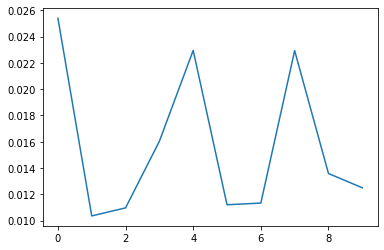

In [4]:
# #blank RMS arrays
# RMS_norm = []
# RMS_scaled = []

# for nf in range(10):
#     # creating blank arrays to store the values from the geometry simulator
#     elements            = [[], [], []] # empty matrix to store each elements data
#     test_elements       = [[], [], []] # empty matrix to store each elements data
#     angleofArrival      = []       # empty matrix to store DoA
#     test_angleofArrival = []       # empty matrix to store DoA
    
    
#     # Generating the training data
#     for i in range(num_sets):
#         output0,output1,output2,anglemp,anglelos = geoSim.f_time_n(num_samples,MP,antenna_dist,nf)
#         elements[0].append(output0)              # storing the data for element 1
#         elements[1].append(output1)              # storing the data for element 2 
#         elements[2].append(output2)              # storing the data for element 3
#         angleofArrival.append(np.mean(anglelos)) # storing the AoA, taking the mean because returns 3 similar angles
#     # Generating the testing data
#     for i in range(test_num_sets):
#         output0,output1,output2,anglemp,anglelos = geoSim.f_time_n(num_samples,MP,antenna_dist,nf)
#         test_elements[0].append(output0)              # storing the data for element 1
#         test_elements[1].append(output1)              # storing the data for element 2 
#         test_elements[2].append(output2)              # storing the data for element 3 
#         test_angleofArrival.append(np.mean(anglelos)) # storing the AoA, taking the mean because returns 3 similar angles
        
#     # Data setup for the correlation
#     # Training Data
#     element1 = np.array(elements[0]) # (number of DoA senarios, number of samples from signal)
#     element2 = np.array(elements[1])
#     element3 = np.array(elements[2])
#     polarCorr, corr = myCorr.cross_corr(element1,element2,num_sets,num_samples) # function currently in wrong file
#     # Testing Data
#     test_element1 = np.array(test_elements[0]) # (number of DoA senarios, number of samples from signal)
#     test_element2 = np.array(test_elements[1])
#     test_element3 = np.array(test_elements[2])
#     test_polarCorr, test_corr = myCorr.cross_corr(test_element1,test_element2,test_num_sets,num_samples) # old cross correlation function
    
    
#     # Create a `Sequential` model and add a Dense layer as the first layer.  
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.Input(shape=(num_samples*2))) # input layer
#     model.add(tf.keras.layers.Dense(num_samples*4, activation = ACTIVATION_FUNCTION)) 
#     model.add(tf.keras.layers.Dense(num_samples*4, activation = ACTIVATION_FUNCTION))
#     model.add(tf.keras.layers.Dense(1024, activation = ACTIVATION_FUNCTION))
#     model.add(tf.keras.layers.Dense(1)) # output layer
#     model.output_shape
    
#     model.compile(
#         optimizer=Adam(learning_rate = LEARNING_RATE),
#         loss='mse',
#         metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
#     # Setting the label and feature
#     train_features, train_labels = prep.data_prep_2_elements(polarCorr,angleofArrival)
#     test_features,  test_labels  = prep.data_prep_2_elements(test_polarCorr,test_angleofArrival)
#     history = model.fit(
#         x = train_features, 
#         y = train_labels,  
#         validation_split = 0.1,
#         batch_size = BATCH_SIZE,
#         epochs = EPOCHS, 
#         verbose = 2)
    
#     # giving the trained NN unseen test data to see how well it learned
#     predictions = model.predict(x=test_features, batch_size=1, verbose=0)
#     # rescaling the normilized output of the NN
#     scaler = MinMaxScaler(feature_range=(np.min(test_angleofArrival),np.max(test_angleofArrival))) 
#     scaled_predictions = scaler.fit_transform(predictions)
#     # changing list to np so it can be reshaped to be used in tables
#     test_angleofArrival = np.array(test_angleofArrival)
#     test_angleofArrival = test_angleofArrival.reshape((test_num_sets,1)) 
#     # eror between pred and actual
    
#     #average rms error
    
    
#     RMS_norm.append(mean_squared_error(predictions, test_labels, squared=False))
#     RMS_scaled.append(mean_squared_error(scaled_predictions,test_angleofArrival, squared=False))
    
    
# plt.plot(RMS_norm)

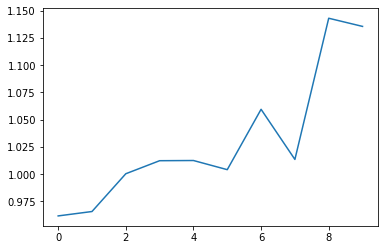

In [5]:
# plt.plot(RMS_scaled)